# Baixar dataset e instalar dependências

In [ ]:
%cd /content
!git clone https://github.com/cadusouza2001/vinho.git
%cd vinho
!pip install -q pandas scikit-learn tensorflow matplotlib

/content
Cloning into 'vinho'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 34 (delta 13), reused 27 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (34/34), 315.19 KiB | 1.25 MiB/s, done.
Resolving deltas: 100% (13/13), done.
/content/vinho


# Realizar Imports

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# Preparação dos dados

In [ ]:
# --- 1. Carregamento e Preparação dos Dados ---

# Carrega os dados de vinho tinto e branco
red = pd.read_csv('winequality-red.csv', sep=';')
white = pd.read_csv('winequality-white.csv', sep=';')

# Adiciona a coluna 'type' para diferenciar os vinhos (0 = tinto, 1 = branco)
red['type'] = 0
white['type'] = 1

# Combina os dois datasets
data = pd.concat([red, white], ignore_index=True)

/tmp/ipython-input-4-2526003179.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='quality_grouped', data=data, palette='viridis')


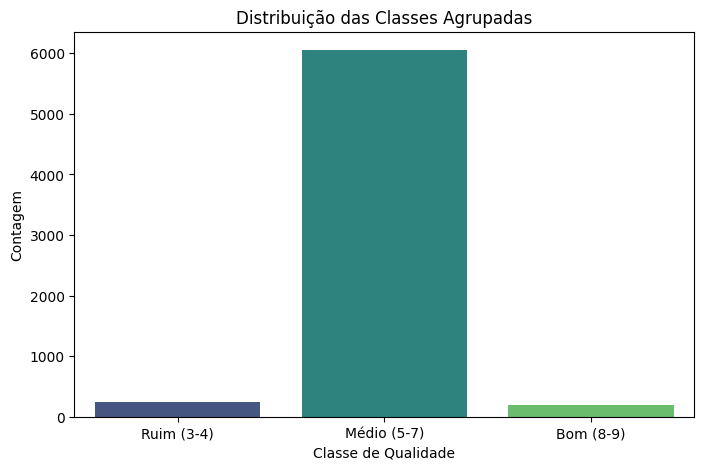

In [ ]:
# --- 2. Agrupamento de Classes e Pré-processamento ---

# Função para agrupar as qualidades em 3 classes: Ruim, Médio, Bom
def agrupar_qualidade(q):
    if q <= 4:
        return 0 # Classe 'Ruim'
    elif q <= 7:
        return 1 # Classe 'Médio'
    else:
        return 2 # Classe 'Bom'

data['quality_grouped'] = data['quality'].apply(agrupar_qualidade)

# Visualiza a nova distribuição das classes
plt.figure(figsize=(8, 5))
sns.countplot(x='quality_grouped', data=data, palette='viridis')
plt.title('Distribuição das Classes Agrupadas')
plt.xlabel('Classe de Qualidade')
plt.xticks(ticks=[0, 1, 2], labels=['Ruim (3-4)', 'Médio (5-7)', 'Bom (8-9)'])
plt.ylabel('Contagem')
plt.show()

# Define o número de classes para o nosso novo problema
num_classes = 3

# Separa as features (X) e o novo rótulo agrupado (y)
X = data.drop(['quality', 'quality_grouped'], axis=1)
y = data['quality_grouped']

# Divisão inicial em treino+validação (80%) e teste (20%) com estratificação
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Divisão do conjunto de treino em treino e validação
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

# Padronização das Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# --- 3. Lidando com o Desbalanceamento (SMOTE) ---

# Aplica o SMOTE APENAS no conjunto de treino
# Com as classes agrupadas, o default k_neighbors=5 deve funcionar sem erro.
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Converte os rótulos para o formato one-hot
y_train_resampled_cat = to_categorical(y_train_resampled, num_classes=num_classes)
y_val_cat = to_categorical(y_val, num_classes=num_classes)

# Construção do modelo de classificação

In [ ]:
# --- 4. Construção do Modelo de Classificação Multiclasse ---

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Camada de saída com 3 neurônios (um para cada classe) e ativação 'softmax'
    Dense(num_classes, activation='softmax')
])

# Compila o modelo
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,883 (42.51 KB)

 Trainable params: 10,499 (41.01 KB)

 Non-trainable params: 384 (1.50 KB)

# Treinamento do modelo

In [ ]:
# --- 5. Treinamento do Modelo ---

# Callback para parar o treinamento
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)

history = model.fit(
    X_train_resampled, y_train_resampled_cat,
    epochs=200,
    batch_size=64,
    validation_data=(X_val_scaled, y_val_cat),
    callbacks=[early_stop]
)

Epoch 1/200
182/182 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 0.5423 - loss: 1.1342 - val_accuracy: 0.5106 - val_loss: 0.9391
Epoch 2/200
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6934 - loss: 0.7080 - val_accuracy: 0.5413 - val_loss: 0.8935
Epoch 3/200
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7134 - loss: 0.6493 - val_accuracy: 0.4875 - val_loss: 0.9337
Epoch 4/200
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7327 - loss: 0.6124 - val_accuracy: 0.5471 - val_loss: 0.8603
Epoch 5/200
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7555 - loss: 0.5706 - val_accuracy: 0.5779 - val_loss: 0.8284
Epoch 6/200
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7580 - loss: 0.5470 - val_accuracy: 0.5567 - val_loss: 0.8588
Epoch 7/200
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7687 - loss: 0.5304 - val_accuracy: 0.6298 - val_loss: 0.7743
Epoch 8/200
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7917 - loss: 0.5007 - val_a

# Avaliação do modelo


--- Avaliação no Conjunto de Teste ---
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

Relatório de Classificação:
              precision    recall  f1-score   support

        Ruim       0.18      0.55      0.27        49
       Médio       0.96      0.81      0.88      1211
         Bom       0.17      0.57      0.26        40

    accuracy                           0.79      1300
   macro avg       0.44      0.64      0.47      1300
weighted avg       0.91      0.79      0.84      1300


Matriz de Confusão:


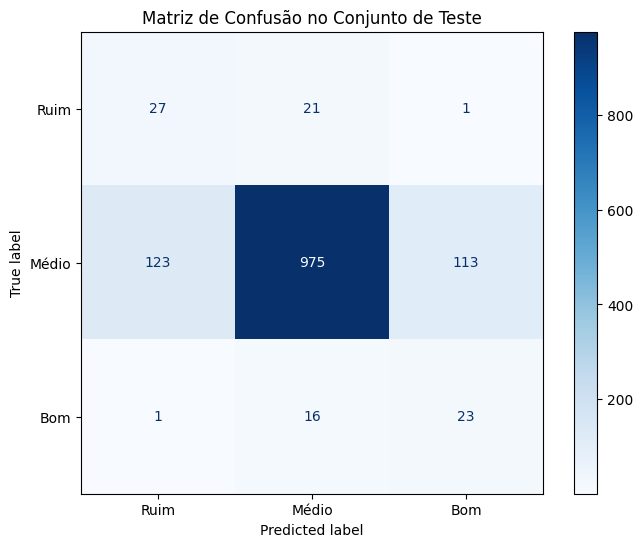

In [ ]:
# --- 6. Avaliação do Modelo Final ---

print("\n--- Avaliação no Conjunto de Teste ---")

# Faz as previsões no conjunto de teste
y_pred_probs = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Nomes das classes para os relatórios
class_labels = ['Ruim', 'Médio', 'Bom']

# Relatório de Classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_classes, target_names=class_labels))

# Matriz de Confusão
print("\nMatriz de Confusão:")
cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues')
plt.title('Matriz de Confusão no Conjunto de Teste')
plt.show()